# Exercise 2

In [1]:
from pset.algorithms import SGA

def run_simulation():
    """Run SGA simulation of the one-max problem."""
    sim = SGA()
    sim.run()
    mean, std, best = sim.fitness_over_time[:]
    assert(len(mean) == len(best))
    for l in [mean, std, best]:
        while len(l) < 100:
            l.append(l[-1])
    return mean, std, best

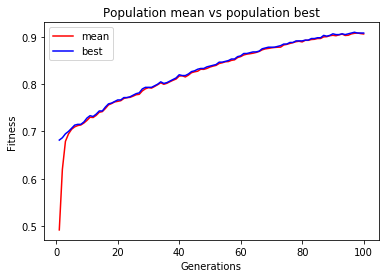

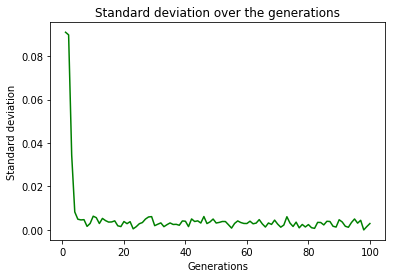

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def update_list(current, new):
    return map(lambda c, n: c + n, current, new)

mean, std, best = [0]*100, [0]*100, [0]*100
for i in range(20):
    m, s, b = run_simulation()
    mean = update_list(mean, m)
    std = update_list(std, s)
    best = update_list(best, b)
    
X = np.array(range(1, 101))
mean = [x/20 for x in mean]
std = [x/20 for x in std]
best = [x/20 for x in best]

plt.figure('Mean vs best')
plt.title("Population mean vs population best")
mean_plt, = plt.plot(X, mean, 'r', label='mean')
best_plt, = plt.plot(X, best, 'b', label='best')
plt.legend(handles=[mean_plt, best_plt])
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.savefig('./assets/ex2_mean.png')
plt.show()

plt.figure('STD')
plt.title("Standard deviation over the generations")
plt.plot(X, std, 'g')
plt.xlabel('Generations')
plt.ylabel('Standard deviation')
plt.savefig('./assets/ex2_std.png')
plt.show()

# Exercise 3

In [4]:
from pset.algorithms import SGA

class CustomSGA(SGA):
    """Custom SGA.
    
    Overrides SGA's run method to yield population
    upon each generation.
    """
    
    def run(self):
        population = self.initialize()
        pop_mean = self.population_fitness(population, update=True)[0]
        yield self.generations, population, pop_mean

        while self.generations < self.MAX_TRIALS and (1 - pop_mean) > self.PRECISION:
            parents = self.select_parents(population)
            offspring = self.recombine(parents)
            self.mutate(offspring)

            population = self.select_new_population(population + offspring, n=self.POP_SIZE)

            pop_mean = self.population_fitness(population, update=True)[0]
            self.generations += 1
            yield self.generations, population, pop_mean

        self.last_pop = population

In [5]:
import numpy as np
import schematax
import time

sim = CustomSGA()

for results in sim.run():
    generation, population, _ = results[0], results[1], results[2]
    file = open('./data/individuals/' + str(generation) + '.txt', 'w')
    file.write('\n'.join([p.chromosome for p in population]))
    file.close()

### Load computed schemas

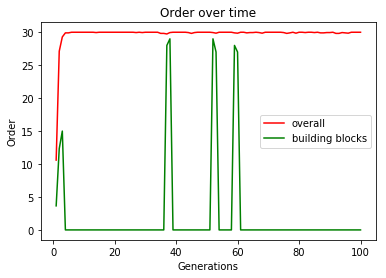

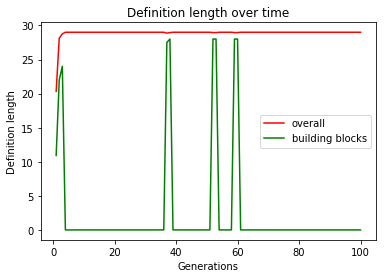

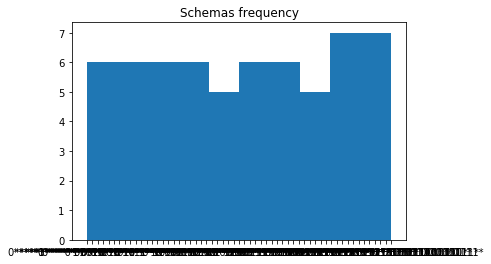

Frequency	Schema
2 :	 *************10*1*0*******111*
2 :	 ****1***10*0*10*1101*1*1**111*
2 :	 *01011111011110111011111001110
1 :	 0*****1****0**0*11**1*********
1 :	 *************10*1**********1**
1 :	 ***********0**0*11************
1 :	 ***********0*10************1**
1 :	 **************0*1***1*********
1 :	 0****************1**1*********
1 :	 0*****1****0**0***************


In [104]:
import numpy as np
import schematax


X = np.array(range(101))

overall_results = {
    'order': [None] * 101,
    'definition_length': [None] * 101
}
building_blocks = {
    'order': [None] * 101,
    'definition_length': [None] * 101,
    'schemas': [],
    'schemas_freq': {}
}

for i in range(1, 101):
    schema_file = open('data/schemas/{}.schema'.format(i), 'r').readlines()
    schemas = []
    for l in schema_file[1:]:
        s = l.split(',')
        schemas.append((s[0], int(s[1]), int(s[2])))

    order = [s[1] for s in schemas]
    definition_length = [s[2] for s in schemas]

    order_m = np.mean(order)
    definition_length_m = np.mean(definition_length)
    overall_results['order'][i] = order_m
    overall_results['definition_length'][i] = definition_length_m

    bbs = []
    for s in schemas:
        if s[1] < order_m and s[2] < definition_length_m:
            bbs.append(s)

    building_blocks['order'][i] = np.mean([x[1] for x in bbs]) if len(bbs) > 0 else 0
    building_blocks['definition_length'][i] = np.mean([x[2] for x in bbs]) if len(bbs) > 0 else 0

    for bb in bbs:
        building_blocks['schemas'].append(bb)
        building_blocks['schemas_freq'][bb[0]] = building_blocks['schemas_freq'].get(bb[0], 0) + 1

        
plt.figure('Schemas order')
plt.title('Order over time')
order_plt, = plt.plot(X, overall_results['order'], 'r', label='overall')
bb_order_plt, = plt.plot(X, building_blocks['order'], 'g', label='building blocks')
plt.xlabel('Generations')
plt.ylabel('Order')
plt.legend(handles=[order_plt, bb_order_plt])
plt.show()

plt.figure('Schemas definition length')
plt.title('Definition length over time')
order_plt, = plt.plot(X, overall_results['definition_length'], 'r', label='overall')
bb_order_plt, = plt.plot(X, building_blocks['definition_length'], 'g', label='building blocks')
plt.xlabel('Generations')
plt.ylabel('Definition length')
plt.legend(handles=[order_plt, bb_order_plt])
plt.show()

plt.figure('Schemas frequency')
plt.title('Schemas frequency')
plt.hist([b[0] for b in building_blocks['schemas']])
plt.show()

top_10 = sorted(building_blocks['schemas_freq'].items(), key=lambda x: x[1], reverse=True)[:10]
print('Frequency\tSchema')
for t in top_10:
    print(t[1], ':\t', t[0])